In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from PIL import Image

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, Dataset

## 1. Dataset
Download the following files for use in this notebook. This will produce a 4-datapoint dataset.

In [2]:
urls = [
    "https://github.com/darksigma/Fundamentals-of-Deep-Learning-Book/raw/master/ch05_implementing_nn_pytorch/data/train/img_0.jpg",
    "https://github.com/darksigma/Fundamentals-of-Deep-Learning-Book/raw/master/ch05_implementing_nn_pytorch/data/train/img_1.jpg",
    "https://github.com/darksigma/Fundamentals-of-Deep-Learning-Book/raw/master/ch05_implementing_nn_pytorch/data/train/img_2.jpg",
    "https://github.com/darksigma/Fundamentals-of-Deep-Learning-Book/raw/master/ch05_implementing_nn_pytorch/data/train/img_3.jpg",
    "https://github.com/darksigma/Fundamentals-of-Deep-Learning-Book/raw/master/ch05_implementing_nn_pytorch/data/train/labels.npy"
]

In [3]:
def download_file(url, path):
    """Download file using the given url."""
    response = requests.get(url)
    if response.status_code == 200:
        with open(path, "wb") as file:
            file.write(response.content)
        return True
    else:
        return False

In [4]:
base_dir = "data"
train_dir = os.path.join(base_dir, "train")

# create the 'data/train' directory if it doesn't exist
os.makedirs(train_dir, exist_ok=True)

download_results = []
for url in urls:
    file_name = url.split('/')[-1]  # extract the file name from the URL
    file_path = os.path.join(train_dir, file_name)
    result = download_file(url, file_path)
    download_results.append((file_name, result))
    
download_results

[('img_0.jpg', True),
 ('img_1.jpg', True),
 ('img_2.jpg', True),
 ('img_3.jpg', True),
 ('labels.npy', True)]

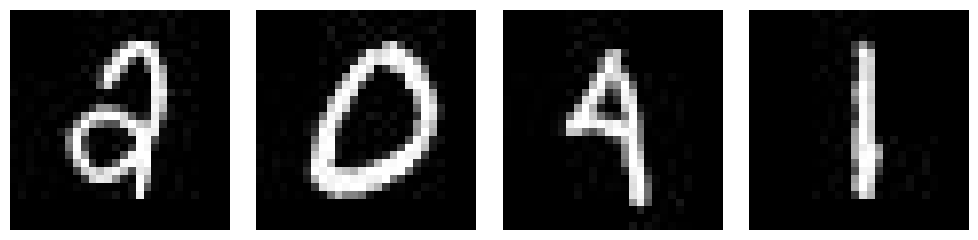

In [5]:
imgs = [file for file in os.listdir(train_dir) if file.endswith('.jpg')]
num_imgs = len(imgs)

# assuming we know the size of the images (e.g., MNIST size 28x28)
# preallocate numpy array for efficiency (flattened image size, number of images)
data = np.empty((num_imgs, 28 * 28), dtype=np.uint8)

fig, axes = plt.subplots(1, num_imgs, figsize=(max(10, num_imgs), 2.5))

for i, img_name in enumerate(imgs):
    image_path = os.path.join(train_dir, img_name)
    image = Image.open(image_path).convert('L')
    im_data = np.array(image)
    data[i] = im_data.flatten()  # store flattened image directly into preallocated array
    
    ax = axes[i] if num_imgs > 1 else axes  # handle the case of a single image
    ax.axis('off')  # hide spines, ticks, etc.
    ax.imshow(im_data, vmin=0, vmax=255, cmap='gray')

plt.tight_layout()
plt.show()

In [6]:
data.shape    # 4 images of size 28x28=784

(4, 784)

## 2. Dimensionality Reduction with PCA

### 2.1 - Using Dataset of 4 Points

#### 2.1.1 - Using `sklearn` PCA Module

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [8]:
# standardize the data
scaler = StandardScaler()
data_std = scaler.fit_transform(data)

In [9]:
pca_mnist_2 = PCA(n_components=2)

# data_pca_2 contains the 2 principal components for each image
data_pca_2 = pca_mnist_2.fit_transform(data_std)

In [10]:
pca_mnist_2.explained_variance_ratio_

array([0.45502879, 0.31244898])

In [11]:
pca_mnist_99 = PCA(n_components=0.99, svd_solver='auto')

# data_pca_99 contains the principal components that retain 99% of the variance
data_pca_99 = pca_mnist_99.fit_transform(data_std)

In [12]:
pca_mnist_99.explained_variance_ratio_

array([0.45502879, 0.31244898, 0.23252223])

#### 2.1.2 - Eigen Decomposition and the Covariance Matrix

In [13]:
# calculate the covariance matrix
cov_matrix = np.cov(data_std.T)

# calculate eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

In [14]:
cov_matrix.shape

(784, 784)

In [15]:
# sort the eigenvalues and eigenvectors
sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices]

#### 2.1.3 - Visualizing PCA Reduction

In [18]:
def visualize_pca(components, labels):
    """Visualize the 2 principal components of PCA, colored by labels.
    - principal_components: 2D numpy array with the principal components.
    - labels: 1D numpy array with the labels for each observation.
    """
    # stack the principal components and labels
    pca_data = np.vstack((components.T, labels)).T
    
    # create a DataFrame for easier plotting
    pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal", "label"))

    # plot using seaborn
    sns.set_style("whitegrid")
    facet_grid = sns.FacetGrid(pca_df, hue="label", height=6, palette="colorblind")
    facet_grid.map(plt.scatter, '1st_principal', '2nd_principal').add_legend()
    plt.title("PCA Visualization with 2 Components")
    plt.show()    

In [19]:
labels_path = "data/train/labels.npy"
labels = np.load(labels_path)

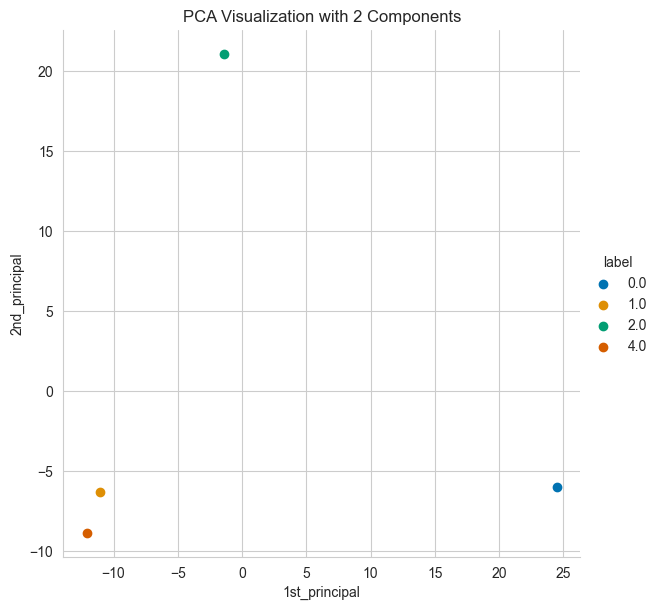

In [20]:
visualize_pca(data_pca_2, labels)

### 2.2 - Using MNIST Dataset of 2500 points

In [21]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Subset

In [22]:
# load the MNIST dataset
train_dataset = MNIST(".", train=True, download=True, transform=ToTensor())
test_dataset = MNIST(".", train=False, download=True, transform=ToTensor())

In [23]:
# subset to simplify the extraction of 2500 random samples
subset_indices = np.random.choice(range(len(test_dataset)), 2500, replace=False)
test_subset = Subset(test_dataset, subset_indices)

In [25]:
len(test_subset)

2500

In [26]:
# flatten the images and extract the labels
images = np.array([test_subset[i][0].numpy().reshape(-1) for i in range(len(test_subset))])
labels = np.array([test_subset[i][1] for i in range(len(test_subset))])

In [27]:
images.shape

(2500, 784)

In [28]:
# standardize the data
scaler = StandardScaler()
images_std = scaler.fit_transform(images)

In [29]:
# PCA to reduce to 2 components
pca_2 = PCA(n_components=2)
images_pca_2 = pca_2.fit_transform(images_std)

In [30]:
# PCA to retain 99% of variance
pca_99 = PCA(n_components=0.99, svd_solver='auto')
images_pca_99 = pca_99.fit_transform(images_std)

#### 2.2.1 - Eigen Decomposition and the Covariance Matrix

In [31]:
# calculate the covariance matrix
cov_matrix = np.cov(images_std.T)

# calculate eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

In [32]:
cov_matrix.shape

(784, 784)

In [33]:
# sort the eigenvalues and eigenvectors
sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices]

#### 2.2.2 - Visualizing PCA Reduction

In [34]:
def plot_mnist_pca_components(components, labels):
    pca_data = np.vstack((components.T, labels)).T
    pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal", "label"))
    
    sns.set_style("whitegrid")
    facet_grid = sns.FacetGrid(pca_df, hue="label", height=6, palette="colorblind")
    facet_grid.map(plt.scatter, '1st_principal', '2nd_principal').add_legend()
    plt.title("MNIST PCA Visualization with 2 Components")
    plt.show()

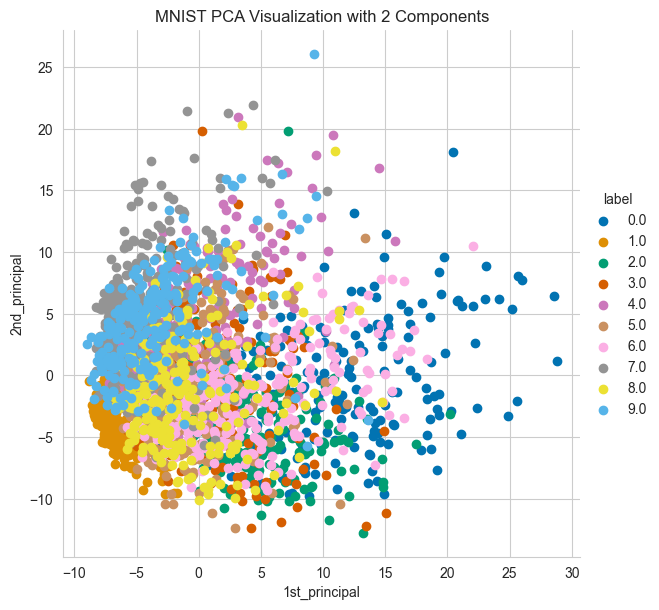

In [35]:
plot_mnist_pca_components(images_pca_2, labels)

## 3. Tensor Manipulation

### 3.1 - Concatenation

Create two arbitrary matrices (`ten1` and `ten2`) of size 2 by 3 each, and then create a third tensor (`tenA`) of size `2 by 6` that concatenates ten1 and ten2.

In [36]:
# create two tensors of size 2x3
ten1 = torch.randn(2, 3)
ten2 = torch.randn(2, 3)

# concatenate ten1 and ten2 to form tenA of size 2x6
tenA = torch.cat((ten1, ten2), dim=1)  # concatenate along columns

In [37]:
print("Tensor 1 (ten1):\n", ten1)
print("Tensor 2 (ten2):\n", ten2)
print("Concatenated Tensor (tenA):\n", tenA)

Tensor 1 (ten1):
 tensor([[ 0.8970, -1.6083, -0.5508],
        [-0.1647, -0.7525, -0.0762]])
Tensor 2 (ten2):
 tensor([[ 0.3981,  0.5368,  1.3484],
        [-2.4620,  0.7766,  1.1007]])
Concatenated Tensor (tenA):
 tensor([[ 0.8970, -1.6083, -0.5508,  0.3981,  0.5368,  1.3484],
        [-0.1647, -0.7525, -0.0762, -2.4620,  0.7766,  1.1007]])


In [38]:
tenA = torch.cat((ten1, ten2), dim=0)  # concatenate along rows

In [39]:
print("Tensor 1 (ten1):\n", ten1)
print("Tensor 2 (ten2):\n", ten2)
print("Concatenated Tensor (tenA):\n", tenA)

Tensor 1 (ten1):
 tensor([[ 0.8970, -1.6083, -0.5508],
        [-0.1647, -0.7525, -0.0762]])
Tensor 2 (ten2):
 tensor([[ 0.3981,  0.5368,  1.3484],
        [-2.4620,  0.7766,  1.1007]])
Concatenated Tensor (tenA):
 tensor([[ 0.8970, -1.6083, -0.5508],
        [-0.1647, -0.7525, -0.0762],
        [ 0.3981,  0.5368,  1.3484],
        [-2.4620,  0.7766,  1.1007]])


### 3.2 - Applying torchvision Transforms

Apply transforms from torchvision (random rotation and random affine including translation and resizing) to an image.

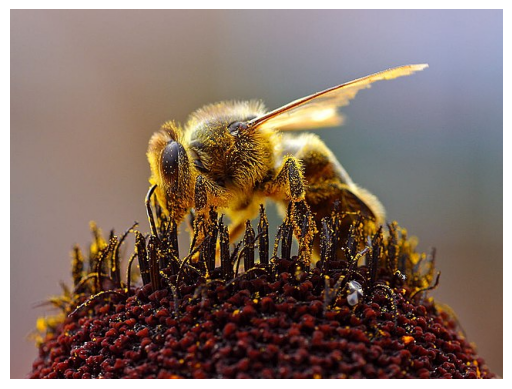

In [45]:
image_path = "files/bee.jpg"
img = Image.open(image_path)

# ensure the image is in RGB mode for correct color representation
if img.mode != 'RGB':
    img = img.convert('RGB')

plt.imshow(img)
plt.axis('off')
plt.show()

In [47]:
from torchvision import transforms

In [48]:
# define the transforms
random_rotation = transforms.RandomRotation(degrees=(0, 180))
random_affine = transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2))

In [49]:
# apply the transforms
img_rotated = random_rotation(img)
img_affine = random_affine(img)

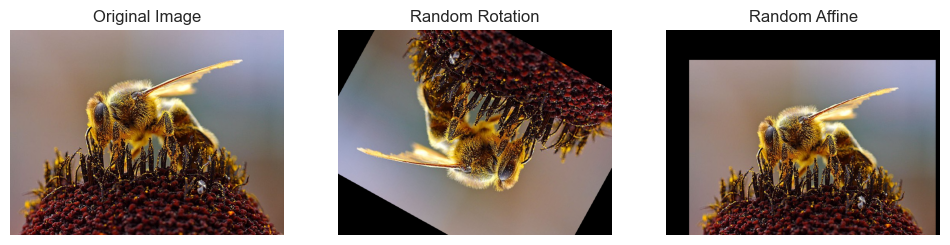

In [50]:
# plot the original and transformed images
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(img, cmap='gray')
axs[0].set_title('Original Image')
axs[0].axis('off')

axs[1].imshow(img_rotated, cmap='gray')
axs[1].set_title('Random Rotation')
axs[1].axis('off')

axs[2].imshow(img_affine, cmap='gray')
axs[2].set_title('Random Affine')
axs[2].axis('off')

plt.show()